# 用TansorFlow 實作MLP 處理手寫數字資料集
甚麼是MLP?<br>
Multilayer perceptron(MLP)前向傳遞類神經網路，包含三層結構(輸入層、隱藏層和輸出層)，並且利用到「倒傳遞」的技術達到學習(model learning)的監督式學習，以上是傳統的定義。現在深度學習的發展，其實MLP是深度神經網路(deep neural network, DNN)的一種special case，概念基本上一樣，DNN只是在學習過程中多了一些手法和層數會更多更深。<br><br>
以下是一個簡單的三層結構當作範例，分別是Input、Hidden、Output。<br>
<img src="image/MLP_結構.jpg" width="400px" /><br>
MLP中有兩個方向的傳遞，分別是前向傳遞跟倒向傳遞
## 前向傳遞(Forward propagation): 較簡單 (只有線性合成，和非線性轉換)
前向傳遞為輸入訊號的加權線性和，經過非線性轉換/激活函數後，再向下傳遞。(以下實作過程，使用relu函數)
<img src="image/relu.jpg" width="200px">
## 反向傳遞 (Backward propagation): 較複雜 (因為多微分方程)
反向傳遞的目的就是利用最後的目標函數來進行參數的更新，一般來說都是用誤差均方和(mean square error)當作目標函數。如果誤差值越大，代表參數學得不好，所以需要繼續學習，直到參數或是誤差值收斂。現在最常用的來收斂的方法是<b>梯度下降演算法(gradient descent)</b>，但這個方法使用的條件是一定要方程式可微分，<b>反向傳遞的目的就是為了加速它的算法</b>。<br><br>
參考資料:<br>https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-%E5%A4%9A%E5%B1%A4%E6%84%9F%E7%9F%A5%E6%A9%9F-multilayer-perceptron-mlp-%E5%90%AB%E8%A9%B3%E7%B4%B0%E6%8E%A8%E5%B0%8E-ee4f3d5d1b41
<br>https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

In [1]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
from tqdm import tqdm
from sklearn.utils import shuffle

np.random.seed(10)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 資料處理
Mnist手寫數字資料集裡，每筆資料是28*28的圖檔，總共有6萬筆資料。而輸出資料則是0~9的數字，一筆輸入對應一筆輸出<br>
注意:電腦是看不懂圖片的，所以我們把28*28的圖檔轉換成陣列，分別是0、1代表有無顏色，再做完轉換後有784個項。<br>
     輸出資料集因為要在最後做分類，所以把0~9做one hot encoding，分成10項。

In [2]:
from keras.datasets import mnist

(X_train_image, y_train_label), (X_test_image, y_test_label) = mnist.load_data()

print("\t[Info] train data={:7,}".format(len(X_train_image)))
print("\t[Info] test  data={:7,}".format(len(X_test_image)))

11493376/11490434 [==============================] - ETA: 12:1 - ETA: 6:0 - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 57 - ETA: 55 - ETA: 52 - ETA: 52 - ETA: 53 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 46 - ETA: 47 - ETA: 45 - ETA: 43 - ETA: 44 - ETA: 43 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 39 - ETA: 39 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 35 - ETA: 35 - ETA: 33 - ETA: 33 - ETA: 31 - ETA: 32 - ETA: 32 - ETA: 30 - ETA: 30 - ETA: 28 - ETA: 29 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 20 - ETA: 21 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 14 - ETA: 14 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:

In [3]:
print("\t[Info] Shape of train data=%s" % (str(X_train_image.shape)))
print("\t[Info] Shape of train label=%s" % (str(y_train_label.shape)))

	[Info] Shape of train data=(60000, 28, 28)
	[Info] Shape of train label=(60000,)


In [4]:
import matplotlib.pyplot as plt
def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='binary') # cmap='binary' 參數設定以黑白灰階顯示
    plt.show()

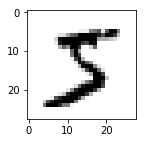

5

In [5]:
plot_image(X_train_image[0])
y_train_label[0]

In [6]:
#用來印出預測結果的涵式
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx], cmap='binary')  
        title = "lable=" + str(labels[idx])  
        if len(prediction) > 0:  
            title = "lable={},prediction={}".format(str(labels[idx]), str(prediction[idx]))  
        else:  
            title = "lable={}".format(str(labels[idx]))  
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1
    plt.show()

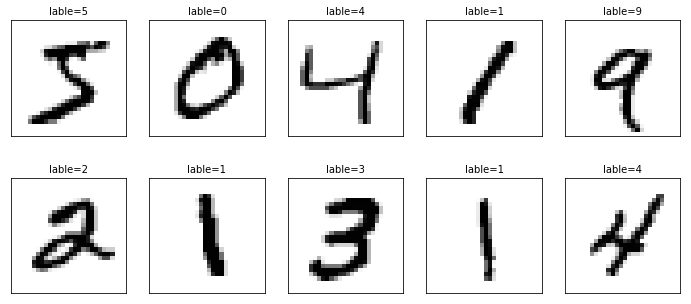

In [7]:
plot_images_labels_predict(X_train_image, y_train_label, [], 0)

# 處理輸入項
將二維的圖片降維之後變成784項數值

In [8]:
x_Train = X_train_image.reshape(60000, 28*28).astype('float32')
x_Test = X_test_image.reshape(10000, 28*28).astype('float32')
print("\t[Info] xTrain: %s" % (str(x_Train.shape)))
print("\t[Info] xTest: %s" % (str(x_Test.shape)))
  
# Normalization
x_Train_norm = x_Train/255
x_Test_norm = x_Test/255

	[Info] xTrain: (60000, 784)
	[Info] xTest: (10000, 784)


# One Hot Encoding
將輸出項(0-9) 轉為陣列0、1表示

In [9]:
y_TrainOneHot = np_utils.to_categorical(y_train_label) # 將 training 的 label 進行 one-hot encoding
y_TestOneHot = np_utils.to_categorical(y_test_label) # 將測試的 labels 進行 one-hot encoding

print(y_train_label[0]) # 檢視 training labels 第一個 label 的值
y_TrainOneHot[:1] # 檢視第一個 label 在 one-hot encoding 後的結果, 會在第六個位置上為 1, 其他位置上為 0

5


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

# 建構網路架構
MLP網路架構總共有三層，分別是輸入層、隱藏層、輸出層。以下例子中，我只建構了一層隱藏層。<br><br>
參數詳細解釋:https://blog.csdn.net/qq_20259459/article/details/53943413

In [10]:
import tensorflow as tf

tf.reset_default_graph() #初始化graph 如果之前沒有定義過graph 可以不用寫

batch_size =32 #gradient descent 批量更新數量
epochs = 100   #總共跑幾次
lr = 0.001     #gradient descent 一次走幾步
#train_ratio=0.9

#----------------------------輸入層--------------------------------
with tf.name_scope('input'):
    x_input = tf.placeholder(shape = (None, x_Train.shape[1]),
                             name = 'x_input',
                             dtype = tf.float32)
    y_out = tf.placeholder(shape = (None, y_TrainOneHot.shape[1]),
                              name = 'y_label',
                              dtype = tf.float32)
#----------------------------隱藏層--------------------------------
#w1、b1 shape要一致
with tf.variable_scope('hidden_layer'):
    w1 = tf.get_variable('weight1',
                         shape = [x_Train.shape[1], 25],
                         dtype = tf.float32,
                         initializer = tf.truncated_normal_initializer(stddev=0.1))
    b1 = tf.get_variable('biasl',
                          shape = [25],
                          dtype = tf.float32,
                          initializer = tf.constant_initializer(0.0))
    x_h1 = tf.nn.relu(tf.add(tf.matmul(x_input, w1), b1))  #(x_input*w1)+b1 再傳入relu激發函數
#----------------------------輸出層--------------------------------
with tf.variable_scope('output_layer'):
    w2 = tf.get_variable('weight2',
                         shape = [25, y_TrainOneHot.shape[1]],
                         dtype = tf.float32,
                         initializer=tf.truncated_normal_initializer(stddev=0.1))
    b2 = tf.get_variable('biasl2',
                         shape = [y_TrainOneHot.shape[1]],
                         dtype = tf.float32,
                         initializer = tf.constant_initializer(0.0))
    output = tf.add(tf.matmul(x_h1, w2), b2)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# 定義涵式
再有了神經網路架構後，還要定義Cross_entropy、Accuracy、Train
* Cross_entropy : 衡量要找出正確答案，不同的策略，所要消耗的成本。計算每個batch完成後，預測結果與答案的差距(Loss Funtion)。
* Accuracy : 累計計算最後的預測率
* Train : 找出能最小化Loss Funtion的結果<br>
結論:Cross_entropy、Train是必要的，而Accuracy不會影響train的過程。<br><br>
Cross_entropy詳細解釋:https://medium.com/@chungyizhen/cross-entropy%E7%9A%84%E7%9B%B4%E8%A7%80%E7%90%86%E8%A7%A3-82e525e3780c

In [ ]:
with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_out))

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output),1), tf.argmax(y_out,1)) #如果答案對則回傳truth
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #將回傳的truth/false轉乘1/0並計算平均(計算正確率)

with tf.name_scope('train'):
    #使用adam做optimization最小化loss funciotn(不斷取微分並逼近local min)
    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.51s/it]


--- training done ---
training accuracy: 0.95
training loss: 0.17


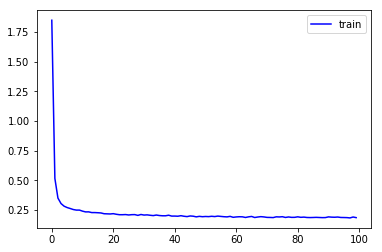

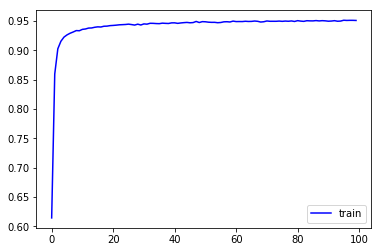

In [11]:
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [], []
#-------------------------------------------------------sess-------------------------------------------------------
with tf.Session() as sess:
    # we have to initalize all variables (e.g. weights/biases) at beginning.
    sess.run([tf.global_variables_initializer()])
    # writer = tf.summary.FileWriter("./graph/", sess.graph)
    for i in tqdm(range(epochs)):
        # get batch 
        total_batch = int(np.floor(len(x_Train) / batch_size)) 
        # 透過batch size 與資料量計算有幾個batch， just drop out last few samples ...
        
        train_loss_collector, train_acc_collector = [], []
        for j in np.arange(total_batch):
            #-------------------------------取一個batch 的資料-------------------------------------
            batch_idx_start = j * batch_size
            batch_idx_stop = (j+1) * batch_size

            x_batch = x_Train[batch_idx_start : batch_idx_stop] 
            y_batch = y_TrainOneHot[batch_idx_start : batch_idx_stop]
            #------------------------------------------------------------------------------------
            this_loss, this_acc, _ = sess.run([loss, compute_acc, train_step], 
                                    feed_dict = {x_input: x_batch,
                                                 y_out: y_batch})
            # run上一個cell最後三個tensor得到loss值,正確率,和一次優化(得到新的weight 和biases)
            train_loss_collector.append(this_loss) #記錄每個batch的loss
            train_acc_collector.append(this_acc)   #記錄每個batch的acc
            
        train_loss_list.append(np.mean(train_loss_collector)) #記錄每個epoch 平均 loss
        train_acc_list.append(np.mean(train_acc_collector))   #記錄每個epoch 平均 acc

        # at the end of each epoch, shuffle the data 重新排列資料並進入下一個i(epochs)
        x_Train, y_TrainOneHot = shuffle(x_Train, y_TrainOneHot)
        
        train_acc, train_loss = sess.run([compute_acc, loss],
                                    feed_dict = {x_input: x_Train,
                                                 y_out : y_TrainOneHot})
print('--- training done ---')
print('training accuracy: %.2f' % train_acc)
print('training loss: %.2f' % train_loss)
#------------------------------------------------------plot----------------------------------------------------------
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b', label = 'train')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b', label = 'train')
plt.legend(loc = 4)
plt.show()